In [116]:
#Load packages
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

from sklearn import datasets
from sklearn import linear_model
from sklearn.model_selection import train_test_split

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline


In [117]:
#Load the training data
col_names = ['A', 'B', 'deltaI', 'deltaR', 'E', 'k']
peak_names = ['peak1', 'peak2', 'peak3', 'peak4', 'peak5']
locs_names = ['loc1', 'loc2', 'loc3', 'loc4', 'loc5']
width_names = ['width1', 'width2', 'width3','width4', 'width5']
prom_names = ['prom1', 'prom2', 'prom3', 'prom4', 'prom5']
col_names = col_names + peak_names + locs_names + width_names + prom_names

data = pd.read_csv('LineCutTrainingData052118_fixedfit.csv', header = None, names = col_names)

#The peak information columns have zeros when there weren't 5 peaks

data.head()

,A,B,deltaI,deltaR,E,k,peak1,peak2,peak3,peak4,...,width1,width2,width3,width4,width5,prom1,prom2,prom3,prom4,prom5
0,-0.38805,-0.22596,0.81472,-0.14798,-0.4,0.06469,0.99666,0.31311,0.19045,0.17845,...,1.4630,46.800,50.281,32.218,0.000,1.27010,0.53509,0.37420,0.15110,0.00000
1,-0.33357,-0.16418,0.81472,-0.14798,-0.3,0.12292,0.82062,0.25860,0.15841,0.13729,...,1.5461,24.827,26.035,27.184,26.446,1.28980,0.45609,0.30073,0.26413,0.20762
2,-0.30657,-0.15064,0.81472,-0.14798,-0.2,0.16228,0.71396,0.23300,0.14533,0.12049,...,1.4174,18.767,19.882,20.103,20.188,1.12150,0.41003,0.27792,0.22411,0.18490
3,-0.28211,-0.14453,0.81472,-0.14798,-0.1,0.19463,0.62981,0.21673,0.13800,0.10512,...,1.3712,15.619,16.632,16.654,17.221,0.99603,0.37978,0.26048,0.20270,0.18805
4,-0.26310,-0.13547,0.81472,-0.14798,0.0,0.22312,0.55621,0.20383,0.13048,0.10268,...,1.3342,13.635,14.398,14.818,14.560,0.87763,0.35828,0.24145,0.19974,0.16361


## Creating the various test, train, data sets

In [118]:
target = data[['deltaI', 'deltaR']]

train1 = data[['A', 'B', 'E', 'k']]
train2 = data[['A', 'B', 'E']]

##Just the entries with E = -0.4
#train_E_04 = train1[train1['E']==-0.4]
#target_E_04 = target[train1['E']==-0.4]
#train_E_04_a = train_E_04[['A', 'B']] 

#Making a copy of the data frame
df1 = data

columns1 = df1.columns
X1 = df1.drop(columns1[2:4], axis = 1) #everything except target
X2 = X1.drop(columns1[6:], axis = 1) # no additional peak info
X3 = X2.drop(columns1[4:6], axis = 1) # no E, k

Y1 = df1[['deltaR']]
Y2 = df1[['deltaI']]
Y3 = pd.DataFrame.join(Y1,Y2)

#Making another copy of the data frame
df2 = df1

#Initializing a new dataframe to use the average peaks, prominences and widths as features instead of each one
new_df = pd.DataFrame(np.zeros([1000,7]), columns = ['deltaI', 'deltaR', 'avgA', 'avgB', 'avgPeak', 'avgWidth', 'avgProm'])
for i in range(1,1001):
        
        temp_df = df2[9*(i-1):9*i]
        columns = temp_df.columns
        new_df['deltaI'][i-1] = temp_df['deltaI'].mean()
        new_df['deltaR'][i-1] = temp_df['deltaR'].mean()
        
        new_df['avgA'][i-1] = temp_df['A'].mean()
        new_df['avgB'][i-1] = temp_df['B'].mean()
        
        new_df['avgPeak'][i-1] = temp_df[columns[6:11]][temp_df[columns[6:11]]>0].mean().mean()
        
        new_df['avgWidth'][i-1] = temp_df[columns[11:16]][temp_df[columns[11:16]]>0].mean().mean()
        
        new_df['avgProm'][i-1] = temp_df[columns[16:21]][temp_df[columns[16:21]]>0].mean().mean()
        
        
#new_df.head()
new_columns = new_df.columns
X_new_df = new_df.drop(new_columns[0:2], axis=1)
Y_new_df = new_df.drop(new_columns[2:], axis = 1)


#### Splitting each dataset in the previous cell into train and test

In [119]:
#Random state
rs = 42
#Test size
ts1 = 0.3

X_a_train, X_a_test, Y_a_train, Y_a_test = train_test_split(train1, target, test_size = ts1, random_state = rs)

X_b_train, X_b_test, Y_b_train, Y_b_test = train_test_split(train2, target, test_size = ts1, random_state = rs)

#Splitting X1, Y1 into train and test
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size = ts1, random_state = rs)

#Splitting X2, Y2 into train and test
X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size = ts1, random_state = rs)

#Splitting X3, Y3 into train and test
X3_train, X3_test, Y3_train, Y3_test = train_test_split(X3, Y3, test_size = ts1, random_state = rs)

#Splitting X_new_df, Y_new_df into train and test
X_new_train, X_new_test, Y_new_train, Y_new_test = train_test_split(X_new_df, Y_new_df, test_size = ts1, random_state = rs)



## Making models

#### Using linear regression from scikit-learn on the minimal data set (only A, phi, E, k as features)

Coefficients: 
 [[ 0.02517025  2.59587981  0.67109299 -2.962225  ]
 [ 3.78402461 -0.54908394  0.21840976 -2.62816891]]
Mean squared error: 0.07
Variance score: 0.467


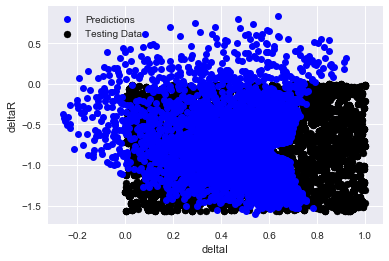

In [195]:
import pylab
#Initialize and fit model to training data
reg = linear_model.LinearRegression()
reg1 = reg.fit(X_a_train, Y_a_train)

#Make predictions using the testing set
y_pred1 = reg1.predict(X_a_test)

# The coefficients
print('Coefficients: \n', reg1.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_a_test, y_pred1))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.3f' % r2_score(Y_a_test, y_pred1))

# Plot outputs
plt.scatter(Y_a_test['deltaI'], Y_a_test['deltaR'],  color=['black'], label = 'Testing Data')
plt.plot(y_pred1[:,0], y_pred1[:,1], 'bo', label = 'Predictions')

# add labels to figure
plt.xlabel('deltaI')
plt.ylabel('deltaR')
pylab.legend(loc='upper left')

In [124]:
iterations = len(Y_a_test['deltaR']) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
SSres_1 = 0 # initializes sum of residuals squared 
for i in range (0,iterations): # for every dot/point
    y_pred1_col = y_pred1[i,1] #get the y value of the line at a specific x value i 
    deltaR = Y_a_test['deltaR'] # get ys of all dots/points 
    deltaR = deltaR.values # take out the indexing, data types, and names
    deltaR = deltaR[i] # get the y value of the dot/point at specfic x value i 
    diff = y_pred1_col - deltaR # find the difference in height 
    diff_squared = (diff)**2 # square the difference 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    SSres_1 = diff_squared + SSres_1 # add squared residual to sum 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual for ys (deltaRs):', round(residual_average,3)) # display average of residuals 

min1 = min(Y_a_test['deltaR']) # find min y 
max1 = max(Y_a_test['deltaR']) # find max y 
range_Y_a_test = min1 + max1 # calculate range 
print('Range:' , round(range_Y_a_test,3)) # print range 
residual_percent_range_Y_a_test = round(((residual_average/abs(range_Y_a_test))*100),3) # calculate what percent residual is of range
print('Y Residual is this percent of range', residual_percent_range_Y_a_test, '%') # display percent 


SStot_1 = np.var(Y_a_test['deltaR']) # calculate variance/total sum of squares 
SSres_1a = SSres_1/iterations # calculate sum of squares of residuals for ys 
R2_1 = round(1 - (SSres_1a/SStot_1),3) # calculate R squared value for ys 
print('Y (deltaR) variance', R2_1) # print r squared value for ys 
################################################################################
iterations = len(Y_a_test['deltaI']) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
SSres_1x = 0 # initializes sum of residuals squared 
for i in range (0,iterations): # for every dot/point
    y_pred1_row = y_pred1[i,0] #get the y value of the line at a specific x value i 
    deltaI = Y_a_test['deltaI'] # get ys of all dots/points 
    deltaI = deltaI.values # take out the indexing, data types, and names
    deltaI = deltaI[i] # get the y value of the dot/point at specfic x value i 
    diff = y_pred1_row - deltaI # find the difference in height 
    diff_squared = (diff)**2 # square the difference 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    SSres_1x = diff_squared + SSres_1x # add squared residual to sum 
residual_averagex = residual_sum/iterations # find the average of the residuals 
print(' ')
print('The average residual for ys (deltaRs):', round(residual_averagex,3)) # display average of residuals 

min1x = min(Y_a_test['deltaI']) # find min x
max1x = max(Y_a_test['deltaI']) # find max x 
range_Y_a_testx = min1x + max1x # calculate range 
print('Domain:' , round(range_Y_a_testx,3)) # print range 
residual_percent_range_Y_a_testx = round(((residual_averagex/abs(range_Y_a_testx))*100),3) # calculate what percent residual is of domain
print('X Residual is this percent of range', residual_percent_range_Y_a_testx, '%') # display percent 


SStot_1x = np.var(Y_a_test['deltaI']) # calculate variance/total sum of squares 
SSres_1xa = SSres_1x/iterations # calculate sum of squares of residuals for xs 
R2_1x = round(1 - (SSres_1xa/SStot_1x),3) # calculate R squared value for xs 
print('X (deltaI) variance', R2_1x) # print r squared value for xs 

The average residual for ys (deltaRs): 0.218
Range: -1.571
Y Residual is this percent of range 13.893 %
Y (deltaR) variance 0.614
 
The average residual for ys (deltaRs): 0.19
Domain: 1.0
X Residual is this percent of range 19.016 %
X (deltaI) variance 0.319


#### Using linear regression from scikit-learn on the data set with only A, phi and E as features (no k). 

Coefficients: 
 [[-0.02598818  2.4676868  -0.20649517]
 [ 3.73863541 -0.66282037 -0.56021102]]
Mean squared error: 0.07
Variance score: 0.46
 
The average residual for ys: 0.219
Range: -1.571
Y Residual is this percent of range 13.916 %
Y (deltaR) variance 0.609
 
The average residual for ys (deltaRs): 0.19
Domain: 1.0
X Residual is this percent of range 19.016 %
X (deltaI) variance 0.319


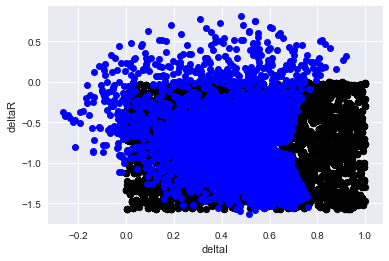

In [127]:
#Initialize and fit model to training data
reg = linear_model.LinearRegression()
reg2 = reg.fit(X_b_train, Y_b_train)

#Make predictions using the testing set
y_pred2 = reg2.predict(X_b_test)

# The coefficients
print('Coefficients: \n', reg2.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_b_test, y_pred2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_b_test, y_pred2))

# Plot outputs
plt.scatter(Y_b_test['deltaI'], Y_b_test['deltaR'],  color=['black'])
plt.plot(y_pred2[:,0], y_pred2[:,1], 'bo')

# add labels to figure
plt.xlabel('deltaI')
plt.ylabel('deltaR')
###############################################

i = 0 # resetting i 
iterations = len(Y_b_test['deltaR']) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
SSres_2 = 0
for i in range (0,iterations): # for every dot/point
    y_pred2_col = y_pred2[i,1] #get the y value of the line at a specific x value i 
    deltaR = Y_b_test['deltaR'] # get ys of all dots/points 
    deltaR = deltaR.values # take out the indexing, data types, and names
    deltaR = deltaR[i] # get the y value of the dot/point at specfic x value i 
    diff = y_pred2_col - deltaR # find the difference in height 
    diff_squared = (diff)**2 # square the difference 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    SSres_2 = diff_squared + SSres_2 # sum the squared residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print(' ')
print('The average residual for ys:', round(residual_average,3)) # display average of residuals 

min2 = min(Y_b_test['deltaR'])
max2 = max(Y_b_test['deltaR'])
range_Y_b_test = min2 + max2
print('Range:' , round(range_Y_b_test,3))
residual_percent_range_Y_b_test = round(((residual_average/abs(range_Y_b_test))*100),3)
print('Y Residual is this percent of range', residual_percent_range_Y_b_test, '%')

SStot_2 = np.var(Y_b_test['deltaR']) # calculate variance/total sum of squares 
SSres_2a = SSres_2/iterations # calculate sum of squares of residuals for ys 
R2_2= round(1 - (SSres_2a/SStot_2),3) # calculate R squared value for ys 
print('Y (deltaR) variance', R2_2) # print r squared value for ys 

################################################################################
iterations = len(Y_b_test['deltaI']) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
SSres_2x = 0 # initializes sum of residuals squared 
for i in range (0,iterations): # for every dot/point
    y_pred1_row = y_pred1[i,0] #get the y value of the line at a specific x value i 
    deltaI = Y_b_test['deltaI'] # get ys of all dots/points 
    deltaI = deltaI.values # take out the indexing, data types, and names
    deltaI = deltaI[i] # get the y value of the dot/point at specfic x value i 
    diff = y_pred1_row - deltaI # find the difference in height 
    diff_squared = (diff)**2 # square the difference 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    SSres_2x = diff_squared + SSres_2x # add squared residual to sum 
residual_average2x = residual_sum/iterations # find the average of the residuals 
print(' ')
print('The average residual for ys (deltaRs):', round(residual_average2x,3)) # display average of residuals 

min2x = min(Y_b_test['deltaI']) # find min x
max2x = max(Y_b_test['deltaI']) # find max x 
range_Y_b_testx = min2x + max2x # calculate range 
print('Domain:' , round(range_Y_b_testx,3)) # print range 
residual_percent_range_Y_b_testx = round(((residual_average2x/abs(range_Y_b_testx))*100),3) # calculate what percent residual is of domain
print('X Residual is this percent of range', residual_percent_range_Y_b_testx, '%') # display percent 


SStot_2x = np.var(Y_b_test['deltaI']) # calculate variance/total sum of squares 
SSres_2xa = SSres_2x/iterations # calculate sum of squares of residuals for xs 
R2_2x = round(1 - (SSres_2xa/SStot_2x),3) # calculate R squared value for xs 
print('X (deltaI) variance', R2_2x) # print r squared value for xs 

Coefficients: 
 [[-0.12604705 -0.33856257 -0.4808321  -0.0758315   0.33135878]
 [ 3.96221684  0.80039848 -2.65795933  0.28968916 -2.64453228]]
Mean squared error: 0.03
Variance score: 0.70
 
The average Y residual: 0.138
Range: -1.576
Y Residual is this percent of range 8.726 %
Y (deltaR) variance 0.824
 
The average X residual (deltaIs): 0.14
Domain: 1.002
X Residual is this percent of range 13.984 %
X (deltaI) variance 0.58


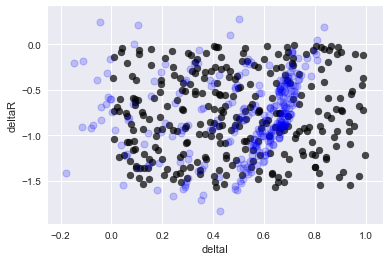

In [131]:
#Initialize and fit model to training data with new columns
reg = linear_model.LinearRegression()
reg_new_lm = reg.fit(X_new_train, Y_new_train)

#Make predictions using the testing set
y_pred_new_lm = reg_new_lm.predict(X_new_test)

# The coefficients
print('Coefficients: \n', reg_new_lm.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(Y_new_test, y_pred_new_lm))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_new_test, y_pred_new_lm))

# Plot outputs
plt.scatter(Y_new_test['deltaI'], Y_new_test['deltaR'],  color=['black'], alpha = 0.7)
plt.scatter(y_pred_new_lm[:,0], y_pred_new_lm[:,1], color='blue', linewidth=1, alpha = 0.2)
# add labels to figure
plt.xlabel('deltaI')
plt.ylabel('deltaR')

#############################################################################
i = 0 # resetting i 
iterations = len(Y_new_test['deltaR']) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
SSres_new = 0 # initialize sum of squared residuals 
for i in range (0,iterations): # for every dot/point
    y_pred_new_lm_col = y_pred_new_lm[i,1] #get the y value of the line at a specific x value i 
    deltaR = Y_new_test['deltaR'] # get ys of all dots/points 
    deltaR = deltaR.values # take out the indexing, data types, and names
    deltaR = deltaR[i] # get the y value of the dot/point at specfic x value i 
    diff = y_pred_new_lm_col - deltaR # find the difference in height 
    diff_squared = (diff)**2 # square the difference 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    SSres_new = diff_squared + SSres_new # sum the squared differences 
residual_average = residual_sum/iterations # find the average of the residuals 
print(' ')
print('The average Y residual:', round(residual_average,3)) # display average of residuals 

min3 = min(Y_new_test['deltaR'])
max3 = max(Y_new_test['deltaR'])
range_Y_new_test = min3 + max3
print('Range:' , round(range_Y_new_test,3))
residual_percent_range_Y_new_test = round(((residual_average/abs(range_Y_new_test))*100),3)
print('Y Residual is this percent of range', residual_percent_range_Y_new_test, '%')

SStot_new = np.var(Y_new_test['deltaR']) # calculate variance/total sum of squares 
SSres_newa = SSres_new/iterations # calculate sum of squares of residuals for ys 
R2_new= round(1 - (SSres_newa/SStot_new),3) # calculate R squared value for ys 
print('Y (deltaR) variance', R2_new) # print r squared value for ys 

################################################################################
iterations = len(Y_new_test['deltaI']) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
SSres_newx = 0 # initializes sum of residuals squared 
for i in range (0,iterations): # for every dot/point
    y_pred_new_lm_row = y_pred_new_lm[i,0] #get the y value of the line at a specific x value i 
    deltaI = Y_new_test['deltaI'] # get ys of all dots/points 
    deltaI = deltaI.values # take out the indexing, data types, and names
    deltaI = deltaI[i] # get the y value of the dot/point at specfic x value i 
    diff = y_pred_new_lm_row - deltaI # find the difference in height 
    diff_squared = (diff)**2 # square the difference 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
    SSres_newx = diff_squared + SSres_newx # add squared residual to sum 
residual_averagenewx = residual_sum/iterations # find the average of the residuals 
print(' ')
print('The average X residual (deltaIs):', round(residual_averagenewx,3)) # display average of residuals 

minnewx = min(Y_new_test['deltaI']) # find min x
maxnewx = max(Y_new_test['deltaI']) # find max x 
range_Y_new_testx = minnewx + maxnewx # calculate range 
print('Domain:' , round(range_Y_new_testx,3)) # print range 
residual_percent_range_Y_new_testx = round(((residual_averagenewx/abs(range_Y_new_testx))*100),3) # calculate what percent residual is of domain
print('X Residual is this percent of range', residual_percent_range_Y_new_testx, '%') # display percent 


SStot_newx = np.var(Y_new_test['deltaI']) # calculate variance/total sum of squares 
SSres_newxa = SSres_newx/iterations # calculate sum of squares of residuals for xs 
R2_newx = round(1 - (SSres_newxa/SStot_newx),3) # calculate R squared value for xs 
print('X (deltaI) variance', R2_newx) # print r squared value for xs 

In [132]:
X_new_train.columns

Index(['avgA', 'avgB', 'avgPeak', 'avgWidth', 'avgProm'], dtype='object')

# Using statsmodels

In [133]:
#Initialize and fit OLS model for deltaR 
model = sm.OLS(Y1_train, X1_train)
results = model.fit()

#Make predictions on testing data
predictions = results.predict(X1_test) # make the predictions by the model

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deltaR   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 1.163e+04
Date:                Tue, 22 May 2018   Prob (F-statistic):               0.00
Time:                        14:42:24   Log-Likelihood:                 2494.4
No. Observations:               15750   AIC:                            -4941.
Df Residuals:                   15726   BIC:                            -4757.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A             -2.5357      0.125    -20.334      0.000      -2.780      -2.291
B             -5.2744      0.100    -52.673      0.000      -5.471      -5.078
E             -0.4775      0.048     -9.898      0.000      -0.572      -0.383
k              1.2470      0.097     12.841      0.000       1.057       1.437
peak1         -0.1295      0.013     -9.699      0.000      -0.156      -0.103
peak2         21.2435      2.496      8.511      0.000      16.351      26.136
peak3          5.7753      2.207      2.617      0.009       1.450      10.100
peak4        -26.8676      1.784    -15.059      0.000     -30.365     -23.371
peak5        -22.2982      1.598    -13.956      0.000     -25.430     -19.166
loc1           0.0016      0.005      0.296      0.768      -0.009       0.012
loc2          -0.0373      0.005     -7.695      0.000      -0.047      -0.028
loc3          -0.0215      0.005     -4.523      0.000      -0.031      -0.012
loc4           0.0162      0.001     11.003      0.000       0.013       0.019
loc5           0.0021      0.003      0.700      0.484      -0.004       0.008
width1         0.0288      0.010      3.007      0.003       0.010       0.048
width2         0.1675      0.028      5.925      0.000       0.112       0.223
width3         0.0282      0.018      1.578      0.115      -0.007       0.063
width4        -0.1633      0.010    -16.796      0.000      -0.182      -0.144
width5         0.0327      0.024      1.381      0.167      -0.014       0.079
prom1          0.0828      0.013      6.365      0.000       0.057       0.108
prom2        -17.7496      1.883     -9.428      0.000     -21.440     -14.060
prom3         -3.1224      1.332     -2.343      0.019      -5.734      -0.511
prom4         16.2630      1.123     14.486      0.000      14.062      18.464
prom5          5.2102      0.825      6.312      0.000       3.592       6.828
==============================================================================
Omnibus:                      247.072   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.894
Skew:                           0.176   Prob(JB):                     7.86e-81
Kurtosis:                       3.662   Cond. No.                     3.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The average residual: [0.15938498]
Residual is this percent of range 5.054 %
Variance score: 0.78


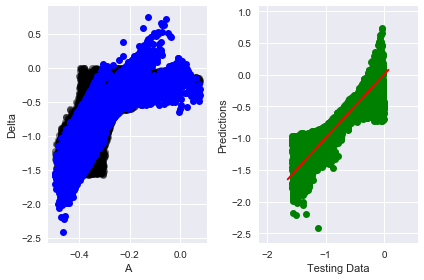

In [150]:
import pylab 
ax = pylab.subplot(121)
ax.plot(X1_test['A'],Y1_test, 'ko', alpha = 0.5)
ax.plot(X1_test['A'], predictions,'bo')
plt.xlabel('A')
plt.ylabel('Delta')

ax = pylab.subplot(122)
ax.plot(Y1_test,predictions, 'go')
xmin,xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-1,xmax+1)
plt.xlabel('Testing Data_I')
plt.ylabel('Predictions')
plt.margins(0.5,1)
plt.tight_layout()

i = 0 # resetting i 
iterations = len(Y1_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y1_test_ys = Y1_test # get ys of testing data 
    Y1_test_ys = Y1_test_ys.values # take out indexing, data types, names
    Y1_test_y = Y1_test_ys[i] # get y value at specific i 
    predictions_ys = predictions # get ys of all dots/points
    predictions_ys = predictions_ys.values # take out the indexing, data types, and names
    predictions_y = predictions_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y1_test_y - predictions_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY1 = min(Y1_test_ys)
maxY1 = max(Y1_test_ys)
minp = min(predictions)
maxp = max(predictions)
#print('minY1', minY1, 'maxY1', maxY1)
#print('minp', minp, 'maxp', maxp)
rangeY1 = minY1 + maxY1 
rangep = minp-maxp
#print('rangeY1', rangeY1)
#print('rangep', rangep)
residual_percent_rangep = (residual_average/abs(rangep))*100
print('Residual is this percent of range', round(residual_percent_rangep[0],3), '%')
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y1_test, predictions))

In [151]:
#Initialize and fit OLS model for deltaI 
model_I = sm.OLS(Y2_train, X1_train)
results_I = model_I.fit()

#Make predictions on testing data
predictions_I = results_I.predict(X1_test) # make the predictions by the model

results_I.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deltaI   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     5047.
Date:                Tue, 22 May 2018   Prob (F-statistic):               0.00
Time:                        15:05:30   Log-Likelihood:                 3308.2
No. Observations:               15750   AIC:                            -6568.
Df Residuals:                   15726   BIC:                            -6384.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A             -4.2288      0.118    -35.709      0.000      -4.461      -3.997
B             -1.5202      0.095    -15.987      0.000      -1.707      -1.334
E             -0.6278      0.046    -13.705      0.000      -0.718      -0.538
k              4.0337      0.092     43.739      0.000       3.853       4.214
peak1         -0.1571      0.013    -12.386      0.000      -0.182      -0.132
peak2        -27.4209      2.370    -11.568      0.000     -32.067     -22.775
peak3          3.7254      2.095      1.778      0.075      -0.382       7.833
peak4        -23.2166      1.694    -13.703      0.000     -26.538     -19.896
peak5        -12.0479      1.517     -7.940      0.000     -15.022      -9.074
loc1          -0.2376      0.005    -46.448      0.000      -0.248      -0.228
loc2           0.0315      0.005      6.838      0.000       0.022       0.040
loc3           0.0194      0.005      4.299      0.000       0.011       0.028
loc4           0.0159      0.001     11.390      0.000       0.013       0.019
loc5          -0.0043      0.003     -1.540      0.124      -0.010       0.001
width1         0.1186      0.009     13.044      0.000       0.101       0.136
width2        -0.0798      0.027     -2.972      0.003      -0.132      -0.027
width3         0.0046      0.017      0.271      0.786      -0.029       0.038
width4        -0.1311      0.009    -14.198      0.000      -0.149      -0.113
width5         0.0700      0.022      3.111      0.002       0.026       0.114
prom1          0.0738      0.012      5.975      0.000       0.050       0.098
prom2         16.2746      1.788      9.103      0.000      12.770      19.779
prom3         -5.1367      1.265     -4.060      0.000      -7.617      -2.657
prom4         10.7953      1.066     10.126      0.000       8.706      12.885
prom5          0.6291      0.784      0.803      0.422      -0.907       2.166
==============================================================================
Omnibus:                      316.239   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              344.849
Skew:                          -0.328   Prob(JB):                     1.31e-75
Kurtosis:                       3.309   Cond. No.                     3.86e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.86e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The average residual: [0.15594224]
Residual is this percent of range 5.102 %
Variance score: 0.55


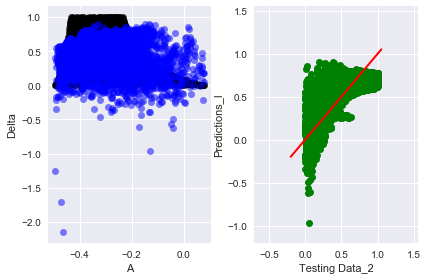

In [158]:
import pylab 
ax = pylab.subplot(121)
ax.plot(X1_test['A'],Y2_test, 'ko', alpha =0.5)
ax.plot(X1_test['A'], predictions_I,'bo', alpha = 0.5)
plt.xlabel('A')
plt.ylabel('Delta')

ax = pylab.subplot(122)
ax.plot(Y2_test,predictions_I, 'go')
xmin, xmax = plt.xlim()
xmin = -0.2
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_2')
plt.ylabel('Predictions_I')
plt.margins(0.5,1)
plt.tight_layout()
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-1,xmax+0.5)

i = 0 # resetting i 
iterations = len(Y2_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y2_test_ys = Y2_test # get ys of testing data 
    Y2_test_ys = Y2_test_ys.values # take out indexing, data types, names
    Y2_test_y = Y2_test_ys[i] # get y value at specific i 
    predictions_I_ys = predictions_I # get ys of all dots/points
    predictions_I_ys = predictions_I_ys.values # take out the indexing, data types, and names
    predictions_I_y = predictions_I_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y2_test_y - predictions_I_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY2 = min(Y2_test_ys)
maxY2 = max(Y2_test_ys)
minp_I = min(predictions_I)
maxp_I = max(predictions_I)
#print('minY2', minY2, 'maxY2', maxY2)
#print('minp_I', minp_I, 'maxp_I', maxp_I)
rangeY2 = minY2 + maxY2 
rangep_I = minp_I-maxp_I
#print('rangeY2', rangeY2)
#print('rangep_I', rangep_I)
residual_percent_rangep_I = (residual_average/abs(rangep_I))*100
print('Residual is this percent of range', round(residual_percent_rangep_I[0],3), '%')
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y2_test, predictions_I))

In [159]:
#Initialize and fit model for just deltaR using A, phi, E, k only
model2 = sm.OLS(Y1_train,X2_train)
results2 = model2.fit()

predictions2 = results2.predict(X2_test)
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deltaR   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                 3.544e+04
Date:                Tue, 22 May 2018   Prob (F-statistic):               0.00
Time:                        15:10:20   Log-Likelihood:                -2450.5
No. Observations:               15750   AIC:                             4909.
Df Residuals:                   15746   BIC:                             4940.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A              3.6283      0.023    154.691      0.000       3.582       3.674
B             -0.8266      0.033    -24.807      0.000      -0.892      -0.761
E             -0.8398      0.021    -40.518      0.000      -0.880      -0.799
k              1.0289      0.047     21.889      0.000       0.937       1.121
==============================================================================
Omnibus:                        0.442   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.802   Jarque-Bera (JB):                0.464
Skew:                           0.010   Prob(JB):                        0.793
Kurtosis:                       2.982   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The average residual: [0.21947773]
Residual is this percent of range 25.814 %
Variance score: 0.60


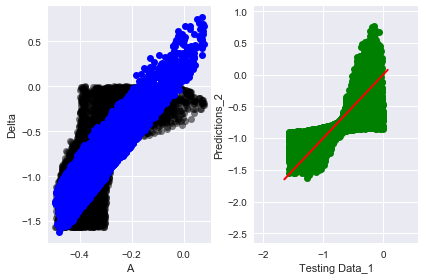

In [163]:
import pylab 
ax = pylab.subplot(121)
ax.plot(X2_test['A'],Y1_test, 'ko', alpha = 0.5)
ax.plot(X2_test['A'], predictions2,'bo')
plt.xlabel('A')
plt.ylabel('Delta')

ax = pylab.subplot(122)
ax.plot(Y1_test,predictions2, 'go')
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_1')
plt.ylabel('Predictions_2')
plt.margins(0.5,1)
plt.tight_layout()
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-1,xmax+1)

i = 0 # resetting i 
iterations = len(Y1_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y1_test_ys = Y1_test # get ys of testing data 
    Y1_test_ys = Y1_test_ys.values # take out indexing, data types, names
    Y1_test_y = Y1_test_ys[i] # get y value at specific i 
    predictions2_ys = predictions2 # get ys of all dots/points
    predictions2_ys = predictions2_ys.values # take out the indexing, data types, and names
    predictions2_y = predictions2_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y1_test_y - predictions2_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY1 = min(Y1_test_ys)
maxY1 = max(Y1_test_ys)
minp2 = min(predictions2)
maxp2 = max(predictions2)
#print('minY1', minY1, 'maxY1', maxY1)
#print('minp2', minp2, 'maxp2', maxp2)
rangeY1 = minY1 + maxY1 
rangep2 = minp2+maxp2
#print('rangeY1', rangeY1)
#print('rangep2', rangep2)
residual_percent_rangep2 = (residual_average/abs(rangep2))*100
print('Residual is this percent of range', round(residual_percent_rangep2[0],3), '%')

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y1_test, predictions2))

In [164]:
#Initialize and fit model for just deltaI using A, phi, E, k only
model2_I = sm.OLS(Y2_train,X2_train)
results2_I = model2_I.fit()

predictions2_I = results2_I.predict(X2_test)
results2_I.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deltaI   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                 1.658e+04
Date:                Tue, 22 May 2018   Prob (F-statistic):               0.00
Time:                        15:12:49   Log-Likelihood:                -729.99
No. Observations:               15750   AIC:                             1468.
Df Residuals:                   15746   BIC:                             1499.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A             -0.2660      0.021    -12.651      0.000      -0.307      -0.225
B              2.0770      0.030     69.524      0.000       2.018       2.136
E             -1.3072      0.019    -70.349      0.000      -1.344      -1.271
k              3.8746      0.042     91.947      0.000       3.792       3.957
==============================================================================
Omnibus:                      271.754   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              265.751
Skew:                          -0.290   Prob(JB):                     1.96e-58
Kurtosis:                       2.739   Cond. No.                         11.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The average residual: [0.20427675]
Residual is this percent of range 33.67 %
Variance score: 0.23


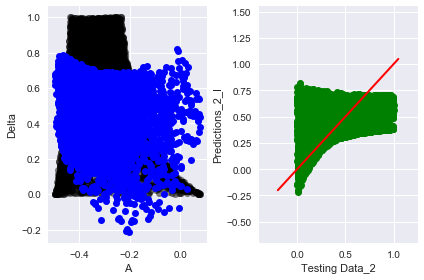

In [167]:
import pylab 
ax = pylab.subplot(121)
ax.plot(X2_test['A'],Y2_test, 'ko', alpha =0.5)
ax.plot(X2_test['A'], predictions2_I,'bo')
plt.xlabel('A')
plt.ylabel('Delta')

ax = pylab.subplot(122)
ax.plot(Y2_test,predictions2_I, 'go')
xmin, xmax = plt.xlim()
xmin = -0.2
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_2')
plt.ylabel('Predictions_2_I')
plt.margins(0.5,1)
plt.tight_layout()
ax.set_xlim(xmin-0.2,xmax+0.2)
ax.set_ylim(xmin-0.5,xmax+0.5)

i = 0 # resetting i 
iterations = len(Y2_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y2_test_ys = Y2_test # get ys of testing data 
    Y2_test_ys = Y2_test_ys.values # take out indexing, data types, names
    Y2_test_y = Y2_test_ys[i] # get y value at specific i 
    predictions2_I_ys = predictions2_I # get ys of all dots/points
    predictions2_I_ys = predictions2_I_ys.values # take out the indexing, data types, and names
    predictions2_I_y = predictions2_I_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y2_test_y - predictions2_I_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY2 = min(Y2_test_ys)
maxY2 = max(Y2_test_ys)
minp2_I = min(predictions2_I)
maxp2_I = max(predictions2_I)
#print('minY2', minY2, 'maxY2', maxY2)
#print('minp2_I', minp2_I, 'maxp2_I', maxp2_I)
rangeY2 = minY2 + maxY2
rangep2_I = minp2_I+maxp2_I
#print('rangeY2', rangeY2)
#print('rangep2_I', rangep2_I)
residual_percent_rangep2_I = (residual_average/abs(rangep2_I))*100
print('Residual is this percent of range', round(residual_percent_rangep2_I[0],3), '%')

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y2_test, predictions2_I))

In [168]:
#Initialize and fit model for just deltaR using A, phi only
model3 = sm.OLS(Y1_train,X3_train)
results3 = model3.fit()

predictions3 = results3.predict(X3_test)
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deltaR   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                 5.880e+04
Date:                Tue, 22 May 2018   Prob (F-statistic):               0.00
Time:                        15:15:06   Log-Likelihood:                -3762.4
No. Observations:               15750   AIC:                             7529.
Df Residuals:                   15748   BIC:                             7544.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A              3.1946      0.018    181.991      0.000       3.160       3.229
B             -1.2471      0.028    -44.177      0.000      -1.302      -1.192
==============================================================================
Omnibus:                      238.798   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              249.604
Skew:                           0.308   Prob(JB):                     6.30e-55
Kurtosis:                       2.988   Cond. No.                         5.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The average residual: [0.24407015]
Residual is this percent of range 12.69 %
Variance score: 0.53


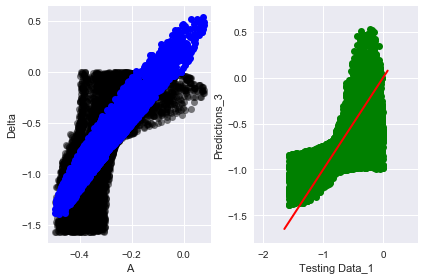

In [171]:
import pylab 
ax = pylab.subplot(121)
ax.plot(X3_test['A'],Y1_test, 'ko', alpha = 0.5)
ax.plot(X3_test['A'], predictions3,'bo')
plt.xlabel('A')
plt.ylabel('Delta')

ax = pylab.subplot(122)
ax.plot(Y1_test,predictions3, 'go')
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_1')
plt.ylabel('Predictions_3')
plt.margins(0.5,1)
plt.tight_layout()
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.15,xmax+0.7)

i = 0 # resetting i 
iterations = len(Y1_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y1_test_ys = Y1_test # get ys of testing data 
    Y1_test_ys = Y1_test_ys.values # take out indexing, data types, names
    Y1_test_y = Y1_test_ys[i] # get y value at specific i 
    predictions3_ys = predictions3 # get ys of all dots/points
    predictions3_ys = predictions3_ys.values # take out the indexing, data types, and names
    predictions3_y = predictions3_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y1_test_y - predictions3_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY1 = min(Y1_test_ys)
maxY1 = max(Y1_test_ys)
minp3 = min(predictions3)
maxp3 = max(predictions3)
#print('minY1', minY1, 'maxY1', maxY1)
#print('minp3', minp3, 'maxp3', maxp3)
rangeY1 = minY1 + maxY1
rangep3 = minp3-maxp3
#print('rangeY1', rangeY1)
#print('rangep3', rangep3)
residual_percent_rangep3 = (residual_average/abs(rangep3))*100
print('Residual is this percent of range', round(residual_percent_rangep3[0],3), '%')

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y1_test, predictions3))

In [172]:
#Initialize and fit model for just deltaI using A, phi only
model3_I = sm.OLS(Y2_train,X3_train)
results3_I = model3_I.fit()

predictions3_I = results3_I.predict(X3_test)
results3_I.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deltaI   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.694
Method:                 Least Squares   F-statistic:                 1.785e+04
Date:                Tue, 22 May 2018   Prob (F-statistic):               0.00
Time:                        15:16:45   Log-Likelihood:                -4408.6
No. Observations:               15750   AIC:                             8821.
Df Residuals:                   15748   BIC:                             8836.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
A             -1.6291      0.018    -89.079      0.000      -1.665      -1.593
B              0.3374      0.029     11.471      0.000       0.280       0.395
==============================================================================
Omnibus:                     1053.217   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              795.789
Skew:                          -0.456   Prob(JB):                    1.57e-173
Kurtosis:                       2.382   Cond. No.                         5.15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The average residual: [0.67782636]
Residual is this percent of range 71.127 %
Variance score: -0.25


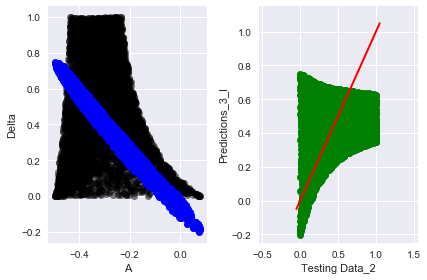

In [175]:
import pylab 
ax = pylab.subplot(121)
ax.plot(X3_test['A'],Y2_test, 'ko', alpha = 0.5)
ax.plot(X3_test['A'], predictions3_I,'bo')
plt.xlabel('A')
plt.ylabel('Delta')
ax = pylab.subplot(122)
ax.plot(Y2_test,predictions3_I, 'go')
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_2')
plt.ylabel('Predictions_3_I')
plt.margins(0.5,1)
plt.tight_layout()
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.2,xmax+0.1)

i = 0 # resetting i 
iterations = len(Y2_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y2_test_ys = Y2_test # get ys of testing data 
    Y2_test_ys = Y2_test_ys.values # take out indexing, data types, names
    Y2_test_y = Y2_test_ys[i] # get y value at specific i 
    predictions3_I_ys = predictions3_I # get ys of all dots/points
    predictions3_I_ys = predictions3_I_ys.values # take out the indexing, data types, and names
    predictions3_I_y = predictions3_I_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y2_test_y - predictions3_I_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY2 = min(Y2_test_ys)
maxY2 = max(Y2_test_ys)
minp3_I = min(predictions3_I)
maxp3_I = max(predictions3_I)
#print('minY2', minY2, 'maxY2', maxY2)
#print('minp3_I', minp3_I, 'maxp3_I', maxp3_I)
rangeY2 = minY2 + maxY2
rangep3_I = minp3_I-maxp3_I
#print('rangeY2', rangeY2)
#print('rangep3_I', rangep3_I)
residual_percent_rangep3_I = (residual_average/abs(rangep3_I))*100
print('Residual is this percent of range', round(residual_percent_rangep3_I[0],3), '%')

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y2_test, predictions3_I))

In [176]:
#Initialize and fit model for just deltaI using newer dataframe with average peak info
model_new1_I = sm.OLS(Y_new_train['deltaI'],X_new_train)
results_new1_I = model_new1_I.fit()

predictions_new1_I = results_new1_I.predict(X_new_test)
results_new1_I.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 deltaI   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     1381.
Date:                Tue, 22 May 2018   Prob (F-statistic):               0.00
Time:                        15:18:51   Log-Likelihood:                 222.95
No. Observations:                 700   AIC:                            -435.9
Df Residuals:                     695   BIC:                            -413.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
avgA          -0.2662      0.185     -1.442      0.150      -0.629       0.096
avgB          -0.3275      0.256     -1.278      0.202      -0.831       0.176
avgPeak       -0.5004      0.157     -3.178      0.002      -0.810      -0.191
avgWidth      -0.0877      0.004    -20.495      0.000      -0.096      -0.079
avgProm        0.4422      0.018     24.692      0.000       0.407       0.477
==============================================================================
Omnibus:                        0.327   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.399
Skew:                          -0.046   Prob(JB):                        0.819
Kurtosis:                       2.928   Cond. No.                     3.36e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.36e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The average residual: 0.1402849910294408
Residual is this percent of range 13.944 %
Variance score: 0.58


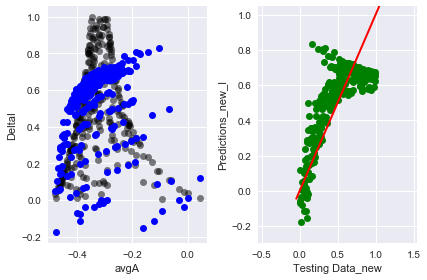

In [187]:
import pylab 
ax = pylab.subplot(121)
ax.plot(X_new_test['avgA'],Y_new_test['deltaI'], 'ko', alpha = 0.5)
ax.plot(X_new_test['avgA'], predictions_new1_I,'bo')
plt.xlabel('avgA')
plt.ylabel('DeltaI')

ax = pylab.subplot(122)
ax.plot(Y_new_test['deltaI'],predictions_new1_I, 'go')
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_new')
plt.ylabel('Predictions_new_I')
plt.margins(0.5,1)
plt.tight_layout()
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.25,xmax)

i = 0 # resetting i 
iterations = len(Y_new_test['deltaI']) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y_new_test_ys = Y_new_test['deltaI'] # get ys of testing data 
    Y_new_test_ys = Y_new_test_ys.values # take out indexing, data types, names
    Y_new_test_y = Y_new_test_ys[i] # get y value at specific i 
    predictions_new1_I_ys = predictions_new1_I # get ys of all dots/points
    predictions_new1_I_ys = predictions_new1_I_ys.values # take out the indexing, data types, and names
    predictions_new1_I_y = predictions_new1_I_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y_new_test_y - predictions_new1_I_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY_new = min(Y_new_test_ys)
maxY_new = max(Y_new_test_ys)
minp_new1_I = min(predictions_new1_I)
maxp_new1_I = max(predictions_new1_I)
#print('minY_new', minY_new, 'maxY_new', maxY_new)
#print('minp_new1_I', minp_new1_I, 'maxp_new1_I', maxp_new1_I)
rangeY_new = minY_new + maxY_new
rangep_new1_I = minp_new1_I-maxp_new1_I
#print('rangeY_new', rangeY_new)
#print('rangep_new1_I', rangep_new1_I)
residual_percent_rangep_new1_I = (residual_average/abs(rangep_new1_I))*100
print('Residual is this percent of range', round(residual_percent_rangep_new1_I,3), '%')

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_new_test['deltaI'], predictions_new1_I))

In [188]:
#Initialize and fit model for just deltaR using newer dataframe with average peak info
model_new1 = sm.OLS(Y_new_train['deltaR'],X_new_train)
results_new1 = model_new1.fit()

predictions_new1 = results_new1.predict(X_new_test)
results_new1.summary2()


<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.940    
Dependent Variable: deltaR           AIC:                -121.5154
Date:               2018-05-22 15:27 BIC:                -98.7600 
No. Observations:   700              Log-Likelihood:     65.758   
Df Model:           5                F-statistic:        2189.    
Df Residuals:       695              Prob (F-statistic): 0.00     
R-squared:          0.940            Scale:              0.048870 
-------------------------------------------------------------------
               Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
avgA           0.6079    0.2311    2.6303  0.0087   0.1541   1.0617
avgB           1.0642    0.3209    3.3165  0.0010   0.4342   1.6943
avgPeak       -3.1267    0.1971  -15.8620  0.0000  -3.5137  -2.7397
avgWidth       0.0054    0.0054    1.0138  0.3110  -0.0051   0.0159
avgProm        0.0085    0.0224    0.3790  0.7048  -0.0355   0.0525
------------------------------------------------------------------
Omnibus:               27.722       Durbin-Watson:          2.056 
Prob(Omnibus):         0.000        Jarque-Bera (JB):       34.779
Skew:                  0.398        Prob(JB):               0.000 
Kurtosis:              3.747        Condition No.:          3359  
==================================================================
* The condition number is large (3e+03). This might indicate
strong multicollinearity or other numerical problems.
"""

The average residual: 0.16276194392859822
Residual is this percent of range 7.031 %
Variance score: 0.58


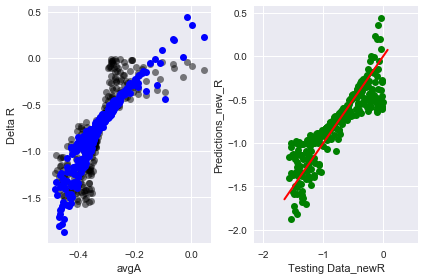

In [190]:

import pylab 
ax = pylab.subplot(121)
ax.plot(X_new_test['avgA'],Y_new_test['deltaR'], 'ko', alpha = 0.5)
ax.plot(X_new_test['avgA'], predictions_new1,'bo')
plt.xlabel('avgA')
plt.ylabel('Delta R')
ax = pylab.subplot(122)
ax.plot(Y_new_test['deltaR'],predictions_new1, 'go')
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_newR')
plt.ylabel('Predictions_new_R')
plt.margins(0.5,1)
plt.tight_layout()
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.5,xmax+0.5)


i = 0 # resetting i 
iterations = len(Y_new_test['deltaR']) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y_new_testR_ys = Y_new_test['deltaR'] # get ys of testing data 
    Y_new_testR_ys = Y_new_testR_ys.values # take out indexing, data types, names
    Y_new_testR_y = Y_new_testR_ys[i] # get y value at specific i 
    predictions_new1_ys = predictions_new1 # get ys of all dots/points
    predictions_new1_ys = predictions_new1_ys.values # take out the indexing, data types, and names
    predictions_new1_y = predictions_new1_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y_new_testR_y - predictions_new1_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY_newR = min(Y_new_testR_ys)
maxY_newR = max(Y_new_testR_ys)
minp_new1 = min(predictions_new1)
maxp_new1 = max(predictions_new1)
#print('minY_newR', minY_newR, 'maxY_newR', maxY_newR)
#print('minp_new1', minp_new1, 'maxp_new1', maxp_new1)
rangeY_newR = minY_newR + maxY_newR
rangep_new1 = minp_new1-maxp_new1
#print('rangeY_newR', rangeY_newR)
#print('rangep_new1', rangep_new1)
residual_percent_rangep_new1 = (residual_average/abs(rangep_new1))*100
print('Residual is this percent of range', round(residual_percent_rangep_new1,3), '%')

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y_new_test['deltaI'], predictions_new1_I))

#### Using statsmodels GLM (generalized linear model)

In [192]:
model4 = sm.GLM(Y1_train,X1_train)
results4 = model4.fit()
predictions4 = results4.predict(X1_test)

results4.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Results: Generalized linear model
=================================================================
Model:              GLM              AIC:            -4940.7837  
Link Function:      identity         BIC:            -151313.6246
Dependent Variable: deltaR           Log-Likelihood: 2494.4      
Date:               2018-05-22 15:31 LL-Null:        -9721.7     
No. Observations:   15750            Deviance:       671.81      
Df Model:           23               Pearson chi2:   672.        
Df Residuals:       15726            Scale:          0.042719    
Method:             IRLS                                         
------------------------------------------------------------------
           Coef.    Std.Err.     z      P>|z|    [0.025    0.975] 
------------------------------------------------------------------
A          -2.5357    0.1247  -20.3336  0.0000   -2.7801   -2.2913
B          -5.2744    0.1001  -52.6728  0.0000   -5.4707   -5.0782
E          -0.4775    0.0482   -9.8981  0.0000   -0.5720   -0.3829
k           1.2470    0.0971   12.8405  0.0000    1.0566    1.4373
peak1      -0.1295    0.0134   -9.6988  0.0000   -0.1557   -0.1033
peak2      21.2435    2.4960    8.5110  0.0000   16.3514   26.1356
peak3       5.7753    2.2066    2.6173  0.0089    1.4505   10.1002
peak4     -26.8676    1.7841  -15.0594  0.0000  -30.3643  -23.3708
peak5     -22.2982    1.5978  -13.9560  0.0000  -25.4297  -19.1667
loc1        0.0016    0.0054    0.2955  0.7676   -0.0090    0.0121
loc2       -0.0373    0.0048   -7.6946  0.0000   -0.0468   -0.0278
loc3       -0.0215    0.0048   -4.5228  0.0000   -0.0309   -0.0122
loc4        0.0162    0.0015   11.0028  0.0000    0.0133    0.0191
loc5        0.0021    0.0030    0.7003  0.4837   -0.0037    0.0079
width1      0.0288    0.0096    3.0074  0.0026    0.0100    0.0476
width2      0.1675    0.0283    5.9252  0.0000    0.1121    0.2229
width3      0.0282    0.0178    1.5775  0.1147   -0.0068    0.0631
width4     -0.1633    0.0097  -16.7963  0.0000   -0.1823   -0.1442
width5      0.0327    0.0237    1.3811  0.1672   -0.0137    0.0792
prom1       0.0828    0.0130    6.3646  0.0000    0.0573    0.1083
prom2     -17.7496    1.8826   -9.4283  0.0000  -21.4394  -14.0598
prom3      -3.1224    1.3324   -2.3434  0.0191   -5.7339   -0.5109
prom4      16.2630    1.1227   14.4861  0.0000   14.0626   18.4634
prom5       5.2102    0.8255    6.3118  0.0000    3.5923    6.8282
=================================================================

"""

The average residual: [0.15938498]
Residual is this percent of range 5.054 %
Variance score: 0.78


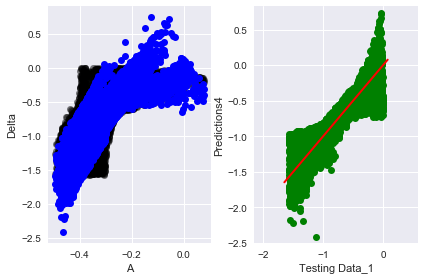

In [221]:
import pylab 
ax = pylab.subplot(121)
ax.plot(X1_test['A'],Y1_test, 'ko', alpha = 0.5)
ax.plot(X1_test['A'], predictions4,'bo')
plt.xlabel('A')
plt.ylabel('Delta')

ax = pylab.subplot(122)
ax.plot(Y1_test,predictions4, 'go')
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_1')
plt.ylabel('Predictions4')
plt.margins(0.5,1)
plt.tight_layout()
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(-2.5,xmax+0.75)

i = 0 # resetting i 
iterations = len(Y1_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y1_test_ys = Y1_test # get ys of testing data 
    Y1_test_ys = Y1_test_ys.values # take out indexing, data types, names
    Y1_test_y = Y1_test_ys[i] # get y value at specific i 
    predictions4_ys = predictions4 # get ys of all dots/points
    predictions4_ys = predictions4_ys.values # take out the indexing, data types, and names
    predictions4_y = predictions4_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y1_test_y - predictions4_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY1 = min(Y1_test_ys)
maxY1 = max(Y1_test_ys)
minp4 = min(predictions4)
maxp4 = max(predictions4)
#print('minY1', minY1, 'maxY1', maxY1)
#print('minp4', minp4, 'maxp4', maxp4)
rangeY1 = minY1 + maxY1
rangep4 = minp4-maxp4
#print('rangeY1', rangeY1)
#print('rangep4', rangep4)
residual_percent_rangep4 = (residual_average/abs(rangep4))*100
print('Residual is this percent of range', round(residual_percent_rangep4[0],3), '%')


# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y1_test, predictions4))

The average residual: [0.15594224]
Residual is this percent of range 5.102 %
Variance score: 0.55


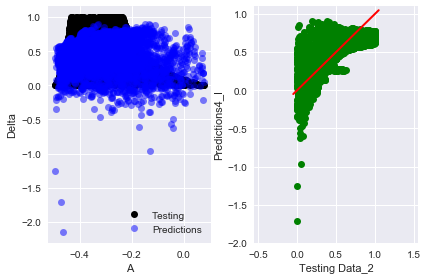

In [220]:
model4_I = sm.GLM(Y2_train,X1_train)
results4_I = model4_I.fit()
predictions4_I = results4_I.predict(X1_test)

results4_I.summary2()

import pylab 
ax = pylab.subplot(121) # put the delta graph in the first subplot position 
ax.plot(X1_test['A'],Y2_test, 'ko', label = 'Testing') # plot the testing data black 
ax.plot(X1_test['A'], predictions4_I,'bo', alpha = 0.5, label = 'Predictions') # plot the prediction data blue 
plt.xlabel('A')
plt.ylabel('Delta')
pylab.legend(loc='lower right')

ax = pylab.subplot(122) # put the testing versus predictions in the second subplot position 
ax.plot(Y2_test,predictions4_I, 'go') # plot the testing versus predictions in green 
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_2')
plt.ylabel('Predictions4_I')
plt.margins(0.5,1)
plt.tight_layout() # does not allow axis labels to overlap
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(-2,xmax+0.05)

i = 0 # resetting i 
iterations = len(Y2_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y2_test_y = Y2_test_ys[i]
    predictions4_I_ys = predictions4_I # get ys of all dots/points
    predictions4_I_ys = predictions4_I_ys.values # take out the indexing, data types, and names
    predictions4_I_y = predictions4_I_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y2_test_y - predictions4_I_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY2 = min(Y2_test_ys) # find the minimum y value for testing data 
maxY2 = max(Y2_test_ys) # find the max y value for testing data 
minp4_I = min(predictions4_I) # find the min y value for the prediction data
maxp4_I = max(predictions4_I) # find the max y value for the prediction data 
#print('minY2', minY2, 'maxY2', maxY2)
#print('minp4_I', minp4_I, 'maxp4_I', maxp4_I)
rangeY2 = minY2 + maxY2 # find the range of the testing data
rangep4_I = minp4_I-maxp4_I # find the range of the predictions 
#print('rangeY2', rangeY2)
#print('rangep4_I', rangep4_I)
residual_percent_rangep4_I = (residual_average/abs(rangep4_I))*100 # calculate what percent the residual is of the range 
print('Residual is this percent of range', round(residual_percent_rangep4_I[0],3), '%')


# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y2_test, predictions4_I)) #calculate and display the r squared score 

The average residual: [0.21947773]
Residual is this percent of range 9.175 %
Variance score: 0.60


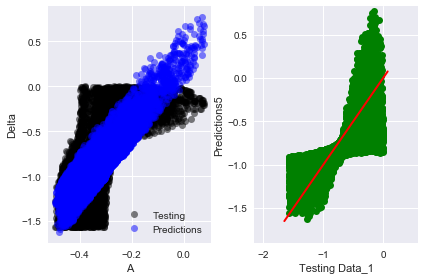

In [212]:
model5 = sm.GLM(Y1_train,X2_train)
results5 = model5.fit()
predictions5 = results5.predict(X2_test)

results5.summary()

import pylab 
ax = pylab.subplot(121) # put the delta graph in the first subplot position 
ax.plot(X2_test['A'],Y1_test, 'ko', alpha = 0.5, label = 'Testing') # plot the testing data black 
ax.plot(X2_test['A'], predictions5,'bo', alpha = 0.5, label = 'Predictions') # plot the prediction data blue 
plt.xlabel('A')
plt.ylabel('Delta')
pylab.legend(loc='lower right')

ax = pylab.subplot(122) # put the testing versus predictions in the second subplot position 
ax.plot(Y1_test,predictions5, 'go') # plot the testing versus predictions in green 
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_1')
plt.ylabel('Predictions5')
plt.margins(0.5,1)
plt.tight_layout() # does not allow axis labels to overlap
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.25,xmax+0.75)

i = 0 # resetting i 
iterations = len(Y1_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y1_test_y = Y1_test_ys[i] # get y value at specific i 
    predictions5_ys = predictions5 # get ys of all dots/points
    predictions5_ys = predictions5_ys.values # take out the indexing, data types, and names
    predictions5_y = predictions5_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y1_test_y - predictions5_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY1 = min(Y1_test_ys) # find the minimum y value for testing data 
maxY1 = max(Y1_test_ys) # find the max y value for testing data 
minp5 = min(predictions5) # find the min y value for the prediction data
maxp5 = max(predictions5) # find the max y value for the prediction data 
#print('minY1', minY1, 'maxY1', maxY1)
#print('minp5', minp5, 'maxp5', maxp5)
rangeY1 = minY1 + maxY1 # find the range of the testing data
rangep5 = minp5-maxp5 # find the range of the predictions 
#print('rangeY1', rangeY1)
#print('rangep5', rangep5)
residual_percent_rangep5 = (residual_average/abs(rangep5))*100 # calculate what percent the residual is of the range 
print('Residual is this percent of range', round(residual_percent_rangep5[0],3), '%')


# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y1_test, predictions5)) #calculate and display the r squared score 

The average residual: [0.20427675]
Residual is this percent of range 19.749 %
Variance score: 0.23


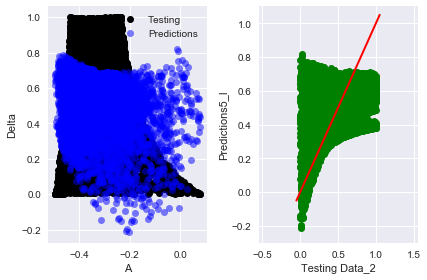

In [218]:
model5_I = sm.GLM(Y2_train,X2_train)
results5_I = model5_I.fit()
predictions5_I = results5_I.predict(X2_test)


#plt.scatter(X2_test['A'],Y2_test, color = 'black', alpha = 0.5)
#plt.scatter(X2_test['A'],predictions5_I)

results5_I.summary2()

import pylab 
ax = pylab.subplot(121) # put the delta graph in the first subplot position 
ax.plot(X2_test['A'],Y2_test, 'ko', label = 'Testing') # plot the testing data black 
ax.plot(X2_test['A'], predictions5_I,'bo', alpha = 0.5, label = 'Predictions') # plot the prediction data blue 
plt.xlabel('A')
plt.ylabel('Delta')
pylab.legend(loc='upper right')

ax = pylab.subplot(122) # put the testing versus predictions in the second subplot position 
ax.plot(Y2_test,predictions5_I, 'go') # plot the testing versus predictions in green 
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_2')
plt.ylabel('Predictions5_I')
plt.margins(0.5,1)
plt.tight_layout() # does not allow axis labels to overlap
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.25,xmax+0.05)



i = 0 # resetting i 
iterations = len(Y2_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y2_test_y = Y2_test_ys[i]
    predictions5_I_ys = predictions5_I # get ys of all dots/points
    predictions5_I_ys = predictions5_I_ys.values # take out the indexing, data types, and names
    predictions5_I_y = predictions5_I_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y2_test_y - predictions5_I_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY2 = min(Y2_test_ys) # find the minimum y value for testing data 
maxY2 = max(Y2_test_ys) # find the max y value for testing data 
minp5_I = min(predictions5_I) # find the min y value for the prediction data
maxp5_I = max(predictions5_I) # find the max y value for the prediction data 
#print('minY2', minY2, 'maxY2', maxY2)
#print('minp5_I', minp5_I, 'maxp5_I', maxp5_I)
rangeY2 = minY2 + maxY2 # find the range of the testing data
rangep5_I = minp5_I-maxp5_I # find the range of the predictions 
#print('rangeY2', rangeY2)
#print('rangep5_I', rangep5_I)
residual_percent_rangep5_I = (residual_average/abs(rangep5_I))*100 # calculate what percent the residual is of the range 
print('Residual is this percent of range', round(residual_percent_rangep5_I[0],3), '%')


# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y2_test, predictions5_I)) #calculate and display the r squared score 

The average residual: [0.24407015]
Residual is this percent of range 12.69 %
Variance score: 0.53


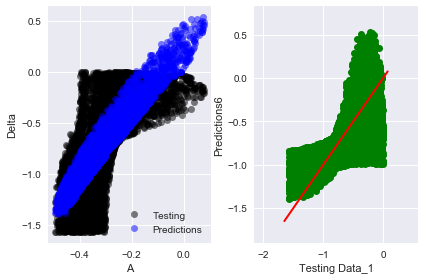

In [224]:
model6 = sm.GLM(Y1_train,X3_train)
results6 = model6.fit()
predictions6 = results6.predict(X3_test)

results6.summary2()

import pylab 
ax = pylab.subplot(121) # put the delta graph in the first subplot position 
ax.plot(X3_test['A'],Y1_test, 'ko', alpha = 0.5, label = 'Testing') # plot the testing data black 
ax.plot(X3_test['A'], predictions6,'bo', alpha = 0.5, label = 'Predictions') # plot the prediction data blue 
plt.xlabel('A')
plt.ylabel('Delta')
pylab.legend(loc='lower right')

ax = pylab.subplot(122) # put the testing versus predictions in the second subplot position 
ax.plot(Y1_test,predictions6, 'go') # plot the testing versus predictions in green 
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_1')
plt.ylabel('Predictions6')
plt.margins(0.5,1)
plt.tight_layout() # does not allow axis labels to overlap
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.25,xmax+0.75)


i = 0 # resetting i 
iterations = len(Y1_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y1_test_y = Y1_test_ys[i] # get y value at specific i 
    predictions6_ys = predictions6 # get ys of all dots/points
    predictions6_ys = predictions6_ys.values # take out the indexing, data types, and names
    predictions6_y = predictions6_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y1_test_y - predictions6_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY1 = min(Y1_test_ys) # find the minimum y value for testing data 
maxY1 = max(Y1_test_ys) # find the max y value for testing data 
minp6 = min(predictions6) # find the min y value for the prediction data
maxp6 = max(predictions6) # find the max y value for the prediction data 
#print('minY1', minY1, 'maxY1', maxY1)
#print('minp6', minp6, 'maxp6', maxp6)
rangeY1 = minY1 + maxY1 # find the range of the testing data
rangep6 = minp6-maxp6 # find the range of the predictions 
#print('rangeY1', rangeY1)
#print('rangep6', rangep6)
residual_percent_rangep6 = (residual_average/abs(rangep6))*100 # calculate what percent the residual is of the range 
print('Residual is this percent of range', round(residual_percent_rangep6[0],3), '%')


# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y1_test, predictions6)) #calculate and display the r squared score 

The average residual: [0.27113054]
Residual is this percent of range 28.451 %
Variance score: -0.25


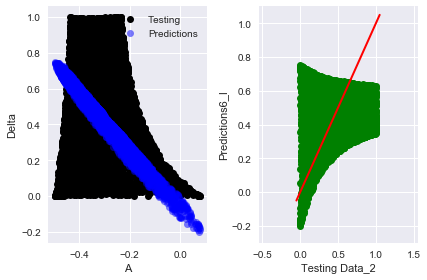

In [226]:
model6_I = sm.GLM(Y2_train,X3_train)
results6_I = model6_I.fit()
predictions6_I = results6_I.predict(X3_test)

results6_I.summary()


import pylab 
ax = pylab.subplot(121) # put the delta graph in the first subplot position 
ax.plot(X3_test['A'],Y2_test, 'ko', label = 'Testing') # plot the testing data black 
ax.plot(X3_test['A'], predictions6_I,'bo', alpha = 0.5, label = 'Predictions') # plot the prediction data blue 
plt.xlabel('A')
plt.ylabel('Delta')
pylab.legend(loc='upper right')

ax = pylab.subplot(122) # put the testing versus predictions in the second subplot position 
ax.plot(Y2_test,predictions6_I, 'go') # plot the testing versus predictions in green 
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_2')
plt.ylabel('Predictions6_I')
plt.margins(0.5,1)
plt.tight_layout() # does not allow axis labels to overlap
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.25,xmax+0.05)



i = 0 # resetting i 
iterations = len(Y2_test) # gets number of dots/points
residual_sum = 0 # initializes sum of residuals
for i in range (0,iterations): # for every dot/point
    Y2_test_y = Y2_test_ys[i]
    predictions6_I_ys = predictions6_I # get ys of all dots/points
    predictions6_I_ys = predictions6_I_ys.values # take out the indexing, data types, and names
    predictions6_I_y = predictions6_I_ys[i] # get the y value of the dot/point at specfic x value i
    diff = Y2_test_y - predictions6_I_y # find the difference in height 
    diff = abs(diff) # take the absolute value 
    residual_sum = diff + residual_sum # add specific residual sum at i to sum of residuals 
residual_average = residual_sum/iterations # find the average of the residuals 
print('The average residual:', residual_average) # display average of residuals 

minY2 = min(Y2_test_ys) # find the minimum y value for testing data 
maxY2 = max(Y2_test_ys) # find the max y value for testing data 
minp6_I = min(predictions6_I) # find the min y value for the prediction data
maxp6_I = max(predictions6_I) # find the max y value for the prediction data 
#print('minY2', minY2, 'maxY2', maxY2)
#print('minp6_I', minp6_I, 'maxp6_I', maxp6_I)
rangeY2 = minY2 + maxY2 # find the range of the testing data
rangep6_I = minp6_I-maxp6_I # find the range of the predictions 
#print('rangeY2', rangeY2)
#print('rangep6_I', rangep6_I)
residual_percent_rangep6_I = (residual_average/abs(rangep6_I))*100 # calculate what percent the residual is of the range 
print('Residual is this percent of range', round(residual_percent_rangep6_I[0],3), '%')


# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(Y2_test, predictions6_I)) #calculate and display the r squared score 

(-1.8985130999999997, 0.1221751)

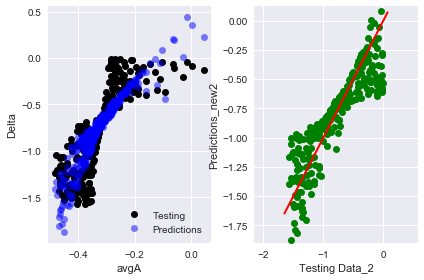

In [229]:
model_new2 = sm.GLM(Y_new_train['deltaR'],X_new_train)
results_new2 = model_new2.fit()
predictions_new2 = results_new2.predict(X_new_test)

results_new2.summary()

import pylab 
ax = pylab.subplot(121) # put the delta graph in the first subplot position 
ax.plot(X_new_test['avgA'],Y_new_test['deltaR'], 'ko', label = 'Testing') # plot the testing data black 
ax.plot(X_new_test['avgA'], predictions_new2,'bo', alpha = 0.5, label = 'Predictions') # plot the prediction data blue 
plt.xlabel('avgA')
plt.ylabel('Delta')
pylab.legend(loc='lower right')

ax = pylab.subplot(122) # put the testing versus predictions in the second subplot position 
ax.plot(Y_new_test['deltaR'],predictions_new2, 'go') # plot the testing versus predictions in green 
xmin, xmax = plt.xlim()
plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one
plt.xlabel('Testing Data_2')
plt.ylabel('Predictions_new2')
plt.margins(0.5,1)
plt.tight_layout() # does not allow axis labels to overlap
ax.set_xlim(xmin-0.5,xmax+0.5)
ax.set_ylim(xmin-0.25,xmax+0.05)



<class 'statsmodels.iolib.summary.Summary'>
"""
                  Generalized Linear Model Regression Results                   
================================================================================
Dep. Variable:                 deltaI   No. Observations:                    700
Model:                            GLM   Df Residuals:                        695
Model Family:                Gaussian   Df Model:                              4
Link Function:               identity   Scale:              0.027793402353724034
Method:                          IRLS   Log-Likelihood:                   263.29
Date:                Tue, 22 May 2018   Deviance:                         19.316
Time:                        12:22:01   Pearson chi2:                       19.3
No. Iterations:                     2                                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
avgA          22.3346      3.484      6.410      0.000      15.506      29.163
avgPhi        -0.1142      0.030     -3.858      0.000      -0.172      -0.056
avgPeak       -0.1401      0.055     -2.542      0.011      -0.248      -0.032
avgWidth      -0.0484      0.007     -7.418      0.000      -0.061      -0.036
avgProm        0.0754      0.061      1.238      0.216      -0.044       0.195
==============================================================================
"""

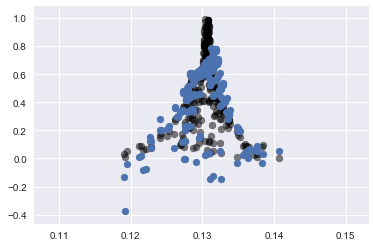

In [34]:
model_new2_I = sm.GLM(Y_new_train['deltaI'],X_new_train)
results_new2_I = model_new2_I.fit()
predictions_new2_I = results_new2_I.predict(X_new_test)


plt.scatter(X_new_test['avgA'],Y_new_test['deltaI'], color = 'black', alpha = 0.5)
plt.scatter(X_new_test['avgA'],predictions_new2_I)

results_new2_I.summary()

### Using Decision Trees in scikit-learn to predict deltaI and deltaR simultaneously

Regression 1 Feature Importance: [1.83162650e-02 3.55891574e-02 0.00000000e+00 0.00000000e+00
 2.16290355e-01 3.89497246e-03 2.94537206e-01 4.02601601e-03
 3.16806875e-02 3.28885049e-03 5.67688155e-02 8.52066504e-03
 1.77661254e-04 2.29041288e-04 2.95601491e-02 2.60070113e-02
 2.03916501e-02 8.18661615e-02 3.03903450e-02 8.50721505e-03
 4.34973071e-04 5.05135316e-03 9.31373484e-03 1.15157714e-01]
Regression 2 Feature Importance: [1.97548115e-02 3.58570305e-02 7.64473748e-05 0.00000000e+00
 2.13905738e-01 3.52381862e-03 2.91185975e-01 6.41430088e-03
 3.24258946e-02 3.53942253e-03 4.32163756e-02 2.11383464e-02
 4.55681986e-04 4.69648188e-04 3.06123786e-02 2.58261169e-02
 2.11177682e-02 8.30109056e-02 3.03993076e-02 1.07193172e-02
 2.91090045e-04 3.30738273e-03 9.22108881e-03 1.13531153e-01]
Regression 3 Feature Importance: [1.96133402e-02 3.58198079e-02 0.00000000e+00 1.94549185e-05
 2.14377266e-01 3.04352025e-03 2.92520729e-01 3.82231139e-03
 3.37192560e-02 1.93852844e-02 4.05334856e-02

array([0.98688529, 0.98724689, 0.9850273 , 0.98297394, 0.98720736,
       0.98028587, 0.98457403, 0.97181232, 0.98251969, 0.97971932])

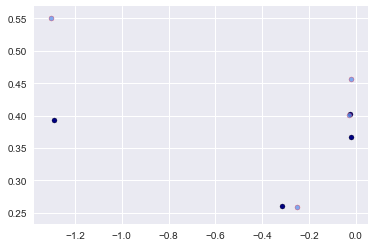

In [35]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor

#Initialize the models
regr_1 = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2 = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3 = DecisionTreeRegressor(max_depth=40, min_samples_leaf=5)

#Fit the models
regr_1.fit(X1_train, Y3_train)
regr_2.fit(X1_train, Y3_train)
regr_3.fit(X1_train, Y3_train)


#Print the coefficients or importances
print('Regression 1 Feature Importance:', regr_1.feature_importances_)
print('Regression 2 Feature Importance:', regr_2.feature_importances_)
print('Regression 3 Feature Importance:', regr_3.feature_importances_)

#Use model to predict
y_1 = regr_1.predict(X1_test)
y_2 = regr_2.predict(X1_test)
y_3 = regr_3.predict(X1_test)

#Plot results
s = 25
plt.scatter(Y3_test.iloc[1:5, 0], Y3_test.iloc[1:5, 1], c="navy", s=s,edgecolor="black", label="data")

#plt.show()
plt.scatter(y_1[1:5, 0], y_1[1:5, 1], c="cornflowerblue", s=s,edgecolor="red", label="data", alpha = 0.8)
#plt.scatter(y_2[1:5, 0], y_2[1:5, 1], c="red", s=10,edgecolor="red", label="data")
#plt.scatter(y_3[1:5, 0], y_3[1:5, 1], c="orange", s=10,edgecolor="black", label="data")

#Trying to understand the scoring
print('Regression 1 Score: ', regr_1.score(X1_test,Y3_test), ', using max depth of 10')
print('Regression 2 Score: ', regr_2.score(X1_test,Y3_test), ', using max depth of 20')
print('Regression 3 Score: ', regr_3.score(X1_test,Y3_test),', using max depth of 30')

from sklearn.model_selection import cross_val_score

regressor = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
cross_val_score(regressor, X1, Y3, cv=10)


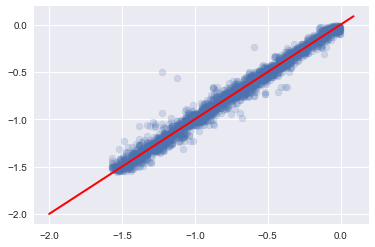

In [36]:
plt.scatter(Y3_test.iloc[:, 0], y_3[:, 0], alpha = 0.2)## deltaR
xmin, xmax = plt.xlim()
xmin = -2


plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

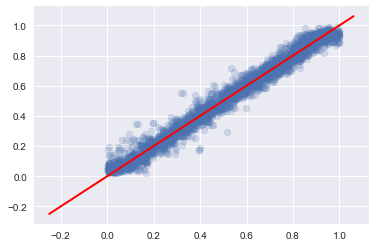

In [37]:
plt.scatter(Y3_test.iloc[:, 1], y_3[:, 1], alpha = 0.2) ## deltaI
xmin, xmax = plt.xlim()
xmin = -0.25


plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

In [38]:
Y3_test.columns

Index(['deltaR', 'deltaI'], dtype='object')

Regression 1a Feature Importance: [0.03643601 0.01696879 0.64617578 0.13667017 0.16374925]
Regression 2a Feature Importance: [0.0318609  0.01603262 0.64635387 0.13846058 0.16729203]
Regression 3a Feature Importance: [0.03554723 0.01654089 0.64598685 0.13769505 0.16422999]
Regression 1 Score:  0.9764785951371223 , using max depth of 10
Regression 2 Score:  0.9765826018104735 , using max depth of 20
Regression 3 Score:  0.976431447460456 , using max depth of 30
Cross Validation Scores:  [0.98630059 0.98738916 0.98840882 0.98771349 0.89758509 0.98444699
 0.98764805 0.96340872 0.97711689 0.98592361]


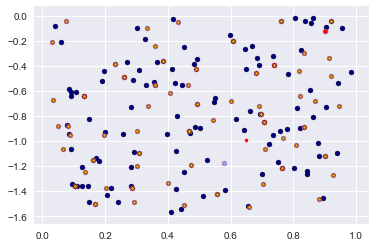

In [39]:
#Decision tree with different X features - average peak info
#Initialize the models
regr_1a = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2a = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3a = DecisionTreeRegressor(max_depth=30, min_samples_leaf=5)

#Fit the models
regr_1a.fit(X_new_train, Y_new_train)
regr_2a.fit(X_new_train, Y_new_train)
regr_3a.fit(X_new_train, Y_new_train)


#Print the coefficients or importances
print('Regression 1a Feature Importance:', regr_1a.feature_importances_)
print('Regression 2a Feature Importance:', regr_2a.feature_importances_)
print('Regression 3a Feature Importance:', regr_3a.feature_importances_)

#Use model to predict
y_1a = regr_1a.predict(X_new_test)
y_2a = regr_2a.predict(X_new_test)
y_3a = regr_3a.predict(X_new_test)

#Plot results
s = 25
plt.scatter(Y_new_test.iloc[1:100, 0], Y_new_test.iloc[1:100, 1], c="navy", s=s,edgecolor="black", label="data")

#plt.show()
plt.scatter(y_1a[1:100, 0], y_1a[1:100, 1], c="cornflowerblue", s=s,edgecolor="red", label="data", alpha = 0.8)
plt.scatter(y_2a[1:100, 0], y_2a[1:100, 1], c="red", s=10,edgecolor="red", label="data")
plt.scatter(y_3a[1:100, 0], y_3a[1:100, 1], c="orange", s=10,edgecolor="black", label="data")

#Trying to understand the scoring
print('Regression 1 Score: ', regr_1a.score(X_new_test,Y_new_test), ', using max depth of 10')
print('Regression 2 Score: ', regr_2a.score(X_new_test,Y_new_test), ', using max depth of 20')
print('Regression 3 Score: ', regr_3a.score(X_new_test,Y_new_test),', using max depth of 30')

regressora = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print('Cross Validation Scores: ', cross_val_score(regressora, X_new_df, Y_new_df, cv=10))

Regression 1b Feature Importance: [0.52022544 0.45819616 0.02056231 0.00101609]
Regression 2b Feature Importance: [0.52076627 0.46186761 0.01523927 0.00212685]
Regression 3b Feature Importance: [0.51482383 0.46830749 0.01505165 0.00181703]
Regression 1 Score:  0.3338952912871864 , using max depth of 10
Regression 2 Score:  0.7078810233036953 , using max depth of 20
Regression 3 Score:  0.7123929599845967 , using max depth of 30
Cross Validation Scores:  [0.7132301  0.73760227 0.74054673 0.72192575 0.79648262 0.76089787
 0.76562454 0.74426662 0.68335088 0.72737562]


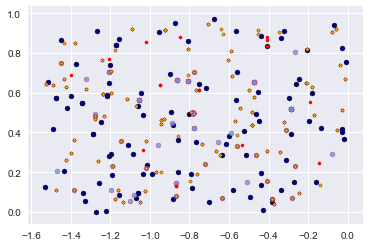

In [40]:
#Decision tree with different X features - no peak info (X2)
#Initialize the models
regr_1b = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2b = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3b = DecisionTreeRegressor(max_depth=30, min_samples_leaf=5)

#Fit the models
regr_1b.fit(X2_train, Y3_train)
regr_2b.fit(X2_train, Y3_train)
regr_3b.fit(X2_train, Y3_train)


#Print the coefficients or importances
print('Regression 1b Feature Importance:', regr_1b.feature_importances_)
print('Regression 2b Feature Importance:', regr_2b.feature_importances_)
print('Regression 3b Feature Importance:', regr_3b.feature_importances_)

#Use model to predict
y_1b = regr_1b.predict(X2_test)
y_2b = regr_2b.predict(X2_test)
y_3b = regr_3b.predict(X2_test)

#Plot results
s = 25
plt.scatter(Y3_test.iloc[1:100, 0], Y3_test.iloc[1:100, 1], c="navy", s=s,edgecolor="black", label="data")

#plt.show()
plt.scatter(y_1b[1:100, 0], y_1b[1:100, 1], c="cornflowerblue", s=s,edgecolor="red", label="data", alpha = 0.8)
plt.scatter(y_2b[1:100, 0], y_2b[1:100, 1], c="red", s=10,edgecolor="red", label="data")
plt.scatter(y_3b[1:100, 0], y_3b[1:100, 1], c="orange", s=10,edgecolor="black", label="data")

#Trying to understand the scoring
print('Regression 1 Score: ', regr_1b.score(X2_test,Y3_test), ', using max depth of 10')
print('Regression 2 Score: ', regr_2b.score(X2_test,Y3_test), ', using max depth of 20')
print('Regression 3 Score: ', regr_3b.score(X2_test,Y3_test),', using max depth of 30')

regressorb = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print('Cross Validation Scores: ', cross_val_score(regressorb, X2, Y3, cv=10))

Regression 1c Feature Importance: [0.56615029 0.43384971]
Regression 2c Feature Importance: [0.53207492 0.46792508]
Regression 3c Feature Importance: [0.5256839 0.4743161]
Regression 1c Score:  0.3255419840221816 , using max depth of 10
Regression 2c Score:  0.66340654787321 , using max depth of 20
Regression 3c Score:  0.6675053554939313 , using max depth of 30
Cross Validation Scores 3c:  [0.66569756 0.69002474 0.69840702 0.6949197  0.75982494 0.70868007
 0.73571992 0.72377234 0.65230926 0.67278855]


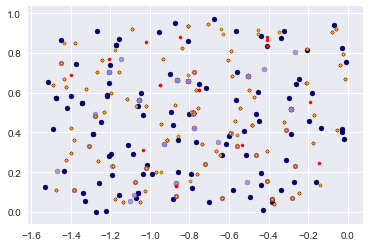

In [41]:
#Decision tree with different X features - just A, phi (X3)
#Initialize the models
regr_1c = DecisionTreeRegressor(max_depth=10, min_samples_leaf=5)
regr_2c = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
regr_3c = DecisionTreeRegressor(max_depth=30, min_samples_leaf=5)

#Fit the models
regr_1c.fit(X3_train, Y3_train)
regr_2c.fit(X3_train, Y3_train)
regr_3c.fit(X3_train, Y3_train)


#Print the coefficients or importances
print('Regression 1c Feature Importance:', regr_1c.feature_importances_)
print('Regression 2c Feature Importance:', regr_2c.feature_importances_)
print('Regression 3c Feature Importance:', regr_3c.feature_importances_)

#Use model to predict
y_1c = regr_1c.predict(X3_test)
y_2c = regr_2c.predict(X3_test)
y_3c = regr_3c.predict(X3_test)

#Plot results
s = 25
plt.scatter(Y3_test.iloc[1:100, 0], Y3_test.iloc[1:100, 1], c="navy", s=s,edgecolor="black", label="data")

#plt.show()
plt.scatter(y_1c[1:100, 0], y_1c[1:100, 1], c="cornflowerblue", s=s,edgecolor="red", label="data", alpha = 0.8)
plt.scatter(y_2c[1:100, 0], y_2c[1:100, 1], c="red", s=10,edgecolor="red", label="data")
plt.scatter(y_3c[1:100, 0], y_3c[1:100, 1], c="orange", s=10,edgecolor="black", label="data")

#Trying to understand the scoring
print('Regression 1c Score: ', regr_1c.score(X3_test,Y3_test), ', using max depth of 10')
print('Regression 2c Score: ', regr_2c.score(X3_test,Y3_test), ', using max depth of 20')
print('Regression 3c Score: ', regr_3c.score(X3_test,Y3_test),', using max depth of 30')

regressorc = DecisionTreeRegressor(random_state=0,max_depth=30, min_samples_leaf=5)
print('Cross Validation Scores 3c: ', cross_val_score(regressorc, X3, Y3, cv=10))

In [42]:
#Visualize a Decision Tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()

export_graphviz(regr_1c, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names=X3_test.columns)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png(path = 'treeTest1.png')
Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

# Random Forest

One way to improve the effectiveness of decision trees and reduce the risk of overfitting, is to implement a random forest, where there are several decision trees and certain nodes within are randomly removed to avoid having one node affect the results too much. Could also use bagging to avoid overfitting. 


From the scikit-learn page for RandomForestRegressor:
A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rs = 42
regr_rf = RandomForestRegressor(max_depth = 6,  random_state=rs)
regr_rf.fit(X1_train, Y3_train)

print('Score: ', regr_rf.score(X1_test, Y3_test))

In [ ]:
pd.Series(regr_rf.feature_importances_, index= X1_train.columns)

In [ ]:
#Trying with a different dataset - average peak info

regr_rf1 = RandomForestRegressor(max_depth = 10, random_state = rs)
regr_rf1 = regr_rf1.fit(X_new_train, Y_new_train)

print('Score: ', regr_rf1.score(X_new_test, Y_new_test)) #R^2 score 

predict1 = pd.DataFrame(regr_rf1.predict(X_new_test), columns = ['deltaI', 'deltaR'])

plt.scatter(Y_new_test['deltaI'], predict1['deltaI'], alpha=0.2)
xmin, xmax = plt.xlim()
xmin = -0.25


plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one

In [ ]:
plt.scatter(Y_new_test['deltaR'], predict1['deltaR'], alpha=0.2)
xmin, xmax = plt.xlim()
xmin = -2


plt.plot([xmin,xmax], [xmin,xmax], c='r', linewidth = 2)  #line with slope of one


In [ ]:
pd.Series(regr_rf1.feature_importances_, index= X_new_train.columns)


In [ ]:
#Save images of each decision tree in the forest
import six
#from sklearn import tree

dotfile = six.StringIO()
i_tree = 0
for tree_in_forest in regr_rf1.estimators_:
    if (i_tree <= len(regr_rf1.estimators_)):        
        export_graphviz(tree_in_forest, out_file=dotfile, feature_names=X_new_train.columns)
        (pydotplus.graph_from_dot_data(dotfile.getvalue())).write_png('dtree_depth6_'+ str(i_tree) +'.png')
        dotfile = six.StringIO()
        i_tree = i_tree + 1

In [ ]:
#Big Change

In [ ]:
#Ken's test change 

In [ ]:
#Laura made a change too
